In [ ]:
# Text Classification
> "Chapter 1 - start out with sentiment text classification."

- toc: true
- branch: master
- badges: false
- comments: false

Text classification is the process of assigning tags or categories to text according to its content. It’s one of the fundamental tasks in natural language processing.

The text we wanna classify is given as input to an algorithm, the algorithm will then analyze the text’s content, and then categorize the input as one of the tags or categories previously given.

**Input → Classifying Algorithm → Classification of Input**

Real life examples:

- sentiment analysis: how does the writer of the sentence feel about what they are writing about, do they think positively or negatively of the subject? Ex. restaurant reviews topic labeling: given sentences and a set of topics, which topic does this sentence fall under? Ex. is this essay about history? Math? etc? spam detection Ex. Email filtering: is this email a real important email or spam?

Example. A restaurant wants to evaluate their ratings but don’t want to read through all of them. Therefore, they wanna use a computer algorithm to do all their work. They simply want to know if the customer’s review is positive or negative.

Here’s an example of a customer’s review and a simple way an algorithm could classify their review.

Input: “The food here was too salty and too expensive”

Algorithm: Goes through every word in the sentence and counts how many positive words and how many negative words are in the sentence.

```
    “The, food, here, was, too, and” are all neutral words

    “Salty, expensive” are negative words.

    Negative words: 2
    Positive words: 0
```

Classification: Negative Review, because there are more negative words (2) than positive (0).

However, this algorithm obviously doesn’t work in a lot of cases.

For example, “The food here was good, not expensive and not salty” would be classified as negative but it’s actually a positive review.

Language and text can get very complicated which makes creating these algorithms difficult. Some things that make language difficult could be words that have multiple meanings, negation words (words such as not), slang, etc.

## Importing Data

This section of code is to import any necessary Python libraries that we'll need for the rest of this notebook, as well as set up the data that we'll be using.

In [4]:
# collapse-hide
!pip3 install seaborn

import sys
import string
from scipy import sparse
from pprint import pprint
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import ipywidgets as widgets 

# Our two files that contain our data, split up into a training set and a testing set.

trainingFile = "trainingSet.txt"
testingFile = "testSet.txt"

  Using cached https://files.pythonhosted.org/packages/68/ad/6c2406ae175f59ec616714e408979b674fe27b9587f79d59a528ddfbcd5b/seaborn-0.11.1-py3-none-any.whl


You are using pip version 10.0.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Let's take a peek at what these text files look like:

In [59]:
#hide_input 

f = open("trainingSet.txt")
file = f.readlines()

sentences = []
sentiments = []

for line in file:
    sentence, sentiment = line.split('\t')
    sentences.append(sentence.strip())
    sentiments.append(int(sentiment.strip())) 
    
print("Sample sentences:")
pprint(sentences[:10]) 
print("Corresponding sentiments:")
pprint(sentiments[:10]) 

Sample sentences:
['Wow... Loved this place.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation '
 'and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead '
 'of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.',
 'Service was very prompt.']
Corresponding sentiments:
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1]


Below is a definition of getData, a basic function to pull from the ```trainingSet.txt``` and ```testSet.txt```. We open the file, create temporary arrays, and pull from the file line by line. 
  

Open the cell if you'd like to peek into what the function looks like.

In [7]:
# collapse-show

def getData(fileName):
    f = open(fileName)
    file = f.readlines()

    sentences = []
    sentiments = []

    for line in file:
        sentence, sentiment = line.split('\t')
        sentences.append(sentence.strip())
        sentiments.append(int(sentiment.strip())) # Sentiment in {0,1}

    return sentences, np.array(sentiments)

In [8]:
# get data from the training and testing files using the getData function defined above

trainingSentences, trainingLabels = getData(trainingFile)
testingSentences, testingLabels = getData(testingFile) 

## Pre-Processing Data

In [9]:
def preProcess(sentences):

    def cleanText(text):
        # Make lower case
        text = text.lower()

        # Replace non-text characters with spaces
        nonText = string.punctuation + ("")
        text = text.translate(str.maketrans(nonText, ' ' * (len(nonText))))

        # Tokenize
        words = text.split()

        return words

    return list(map(cleanText, sentences))

In [10]:
trainingTokens = preProcess(trainingSentences)
testingTokens = preProcess(testingSentences)

## Getting Data and Setting it Up

In [11]:
def getVocab(sentences):
    vocab = set()
    for sentence in sentences:
        for word in sentence:
            vocab.add(word)
    return sorted(vocab)

In [12]:
vocabulary = getVocab(trainingTokens)

In [13]:
def clicked(arg):
    print(vocabulary)

button_download = widgets.Button(description = 'Click to see Vocab')   
button_download.on_click(clicked)
display(button_download)

Button(description='Click to see Vocab', style=ButtonStyle())

In [14]:
def createVector(vocab, sentences):
    indices = []
    wordOccurrences = []

    for sentenceIndex, sentence in enumerate(sentences):
        alreadyCounted = set() # Keep track of words so we don't double count.
        for word in sentence:
            if (word in vocab) and word not in alreadyCounted:
                # If we just want {0,1} for the presence of the word (bernoulli NB),
                # only count each word once. Otherwise (multinomial NB) count each
                # occurrence of the word.
                
            
                #which sentence, which word
                indices.append((sentenceIndex, vocab.index(word)))
                
                wordOccurrences.append(1)
                alreadyCounted.add(word)

    # Unzip
    rows = [row for row, _ in indices]
    columns = [column for _, column in indices]

    sentenceVectors = sparse.csr_matrix((wordOccurrences, (rows, columns)), dtype=int, shape=(len(sentences), len(vocab)))

    return sentenceVectors

In [15]:
training = createVector(vocabulary, trainingTokens)
testing = createVector(vocabulary, testingTokens)

In [16]:
import numpy as np


class NaiveBayesClassifier:
    def __init__(self):
        self.priorPositive = None  # Probability that a review is positive
        self.priorNegative = None  # Probability that a review is negative
        self.positiveLogConditionals = None
        self.negativeLogConditionals = None

    def computePriorProbabilities(self, labels):
        self.priorPositive = len([y for y in labels if y == 1]) / len(labels)
        self.priorNegative = 1 - self.priorPositive

    def computeConditionProbabilities(self, examples, labels, dirichlet=1):
        _, vocabularyLength = examples.shape

        # How many of each word are there in all of the positive reviews
        positiveCounts = np.array([dirichlet for _ in range(vocabularyLength)])
        # How many of each word are there in all of the negative reviews
        negativeCounts = np.array([dirichlet for _ in range(vocabularyLength)])

        # Here's how to iterate through a spare array
        coordinates = examples.tocoo()  # Converted to a `coordinate` format
        for exampleIndex, featureIndex, observationCount in zip(coordinates.row, coordinates.col, coordinates.data):
            # For sentence {exampleIndex}, for word at index {featureIndex}, the word occurred {observationCount} times
            if labels[exampleIndex] == 1:
                positiveCounts[featureIndex] += observationCount
            else:
                negativeCounts[featureIndex] += observationCount

        # [!] Make sure to use the logs of the probabilities
        positiveReviewCount = len([y for y in labels if y == 1])
        negativeReviewCount = len([y for y in labels if y == 0])

        # We are using bernoulli NB
        self.positiveLogConditionals = np.log(positiveCounts) - np.log(positiveReviewCount + dirichlet*2)
        self.negativeLogConditionals = np.log(negativeCounts) - np.log(negativeReviewCount + dirichlet*2)

        # This works for multinomial NB
        # self.positiveLogConditionals = np.log(positiveCounts) - np.log(sum(positiveCounts))
        # self.negativeLogConditionals = np.log(negativeCounts) - np.log(sum(negativeCounts))

    # Calculate all of the parameters for making a naive bayes classification
    def fit(self, trainingExamples, trainingLabels):
        # Compute the probability of positive/negative review
        self.computePriorProbabilities(trainingLabels)

        # Compute
        self.computeConditionProbabilities(trainingExamples, trainingLabels)

    def computeLogPosteriors(self, sentence):
        return ((np.log(self.priorPositive) + sum(sentence * self.positiveLogConditionals)),
                (np.log(self.priorNegative) + sum(sentence * self.negativeLogConditionals)))

    def predict(self, examples):
        totalReviewCount, _ = examples.shape

        predictions = np.array([0 for _ in range(totalReviewCount)])

        for index, sentence in enumerate(examples):
            logProbabilityPositive, logProbabilityNegative = self.computeLogPosteriors(
                sentence)
            predictions[index] = 1 if logProbabilityPositive > logProbabilityNegative else 0

        return predictions

In [17]:
nbClassifier = NaiveBayesClassifier()
nbClassifier.fit(training, trainingLabels)

In [18]:
def accuracy(predictions, actual):
    return sum((predictions == actual)) / len(actual)

In [19]:
trainingPredictions = nbClassifier.predict(training)
testingPredictions = nbClassifier.predict(testing)

In [20]:
def accuracy_button(arg):
    print("Training accuracy:", accuracy(trainingPredictions, trainingLabels))
    print("Testing accuracy:", accuracy(testingPredictions, testingLabels))

button_download = widgets.Button(description = 'Model Accuracy')   
button_download.on_click(accuracy_button)
display(button_download)

Button(description='Model Accuracy', style=ButtonStyle())

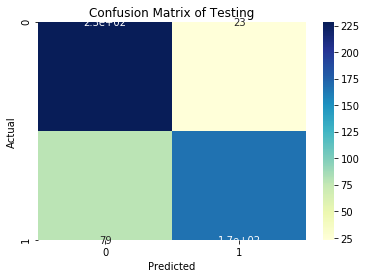

In [21]:
data = {'Actual':    testingLabels,
        'Predicted': testingPredictions
        }

df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True,cmap="YlGnBu").set_title('Confusion Matrix of Testing')
plt.show()
